In [ ]:
import json
import numpy as np
import time
import pandas as pd

Mounted at /content/drive


In [ ]:
# import mutations et nb distance
nb_distance = pd.read_csv("BDD_output/bdd_nb_distance.csv")
nb_distance.set_index("idmutinvar", inplace=True)
nb_distance["arrondissement"] = nb_distance["l_codinsee"].astype(str).apply(lambda x : x[3:]+ "e arr"
                                                                          if x[3:].startswith("0") == False
                                                                          else x[4:] + "e arr")
nb_distance = nb_distance.loc[nb_distance['sbati'] != 0]
nb_distance.loc[:,"prixm2"] = nb_distance["valeurfonc"] / nb_distance["sbati"]
nb_distance.drop(["anneemut","datemut"]+
                ["id_parcelles","coor_parcelles","long_parcelles","lat_parcelles","coddep","l_codinsee"]+
                ["valeurfonc","sbati"],
                inplace=True, axis=1)

<ipython-input-58-eca7a23563b0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nb_distance.loc[:,"prixm2"] = nb_distance["valeurfonc"] / nb_distance["sbati"]
<ipython-input-58-eca7a23563b0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nb_distance.drop(["anneemut","datemut"]+


In [ ]:
# import dist_min
data_min = pd.read_csv("BDD_output/bdd_min_dist.csv")
data_min.set_index("idmutinvar", inplace=True)

In [ ]:
# merge in a final dataset
final_data = pd.merge(nb_distance, data_min.filter(regex='^min_dist'), on='idmutinvar', how = 'left')

In [ ]:
# Retrieve extreme values
final_data = final_data.loc[final_data['prixm2']<15000]
final_data = final_data.loc[final_data['prixm2']>6000]

0.018616323603994334%  rows are removed


In [ ]:
final_data.shape

(114362, 31)

# LASSO Model (6k - 15k per m2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import Lasso, Ridge
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_data.drop("prixm2",axis=1),
                                                   final_data["prixm2"],
                                                   test_size=0.2,
                                                   random_state=42)
print(X_train.shape)
print(X_test.shape)

(76670, 30)
(19168, 30)


In [ ]:
categorical_cols = final_data.drop('prixm2',axis=1).select_dtypes(include=['object']).columns
numerical_cols = final_data.drop('prixm2',axis=1).select_dtypes(exclude=['object']).columns

# preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train_trans = pd.DataFrame(preprocessor.fit_transform(X_train))
print(X_train_trans.shape)
X_test_trans = pd.DataFrame(preprocessor.fit_transform(X_test))
print(X_test_trans.shape)

(76670, 51)
(19168, 51)


In [ ]:
start_time = time.time()

lasso_model = Lasso(max_iter=50000)

lasso_param = {'alpha':  np.arange(0.001, 1, 0.05) }

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rmse = make_scorer(mean_squared_error, squared=False)

grid_lasso = GridSearchCV(estimator=lasso_model,
                          param_grid = lasso_param,
                          scoring=rmse,
                          refit='r2',
                          cv=cv,
                          error_score='raise',
                          n_jobs=-1)

grid_lasso.fit(X_train_trans, y_train)

print("LASSO RESULTS")
print(f"Mean square error : {grid_lasso.cv_results_['mean_test_score'].mean()}")
print(f"Best parameter : {grid_lasso.best_params_}")
#print(f"Best score : {grid_lasso.best_score_}")

print(f"{int(round(time.time() - start_time,0)//60)} min {int(round(time.time() - start_time,0)%60)}")

LASSO RESULTS
Mean square error : 1722.732740035426
Best parameter : {'alpha': 0.9510000000000001}
18 min 44


### Results

In [ ]:
print("\nLASSO RESULTS")
lasso_model = Lasso(alpha=grid_lasso.best_params_['alpha'],
                 fit_intercept=True,
                 max_iter=50000)
lasso_model.fit(X_train_trans, y_train)
y_test_valid_lm = lasso_model.predict(X_test_trans)

print('Mean Squared Error (MSE):', np.sqrt(metrics.mean_squared_error(y_test, y_test_valid_lm)))
print('R^2:', metrics.r2_score(y_test, y_test_valid_lm))


LASSO RESULTS
Mean Squared Error (MSE): 1715.3425529327042
R^2: 0.21071265153075514


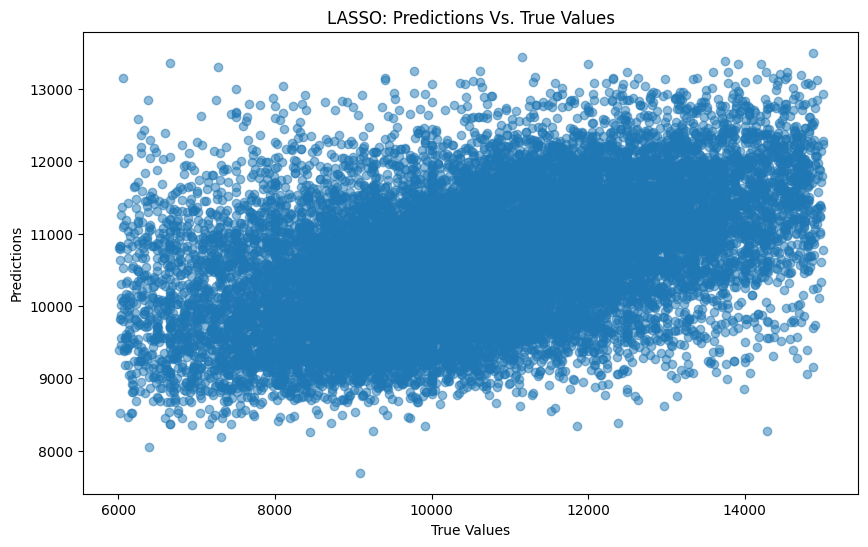

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.DataFrame({'True Values': y_test, 'Predictions': y_test_valid_lm})

plt.figure(figsize=(10, 6))
plt.scatter(results_df['True Values'], results_df['Predictions'], alpha=0.5)

plt.title('LASSO: Predictions Vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# LASSO for extreme values (> 15k)

In [ ]:
final_data = pd.merge(nb_distance, data_min.filter(regex='^min_dist'), on='idmutinvar', how = 'left')

In [ ]:
extreme_values = final_data.loc[final_data["prixm2"]>=15000]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(extreme_values.drop("prixm2",axis=1),
                                                   extreme_values["prixm2"],
                                                   test_size=0.2,
                                                   random_state=42)
print(X_train.shape)
print(X_test.shape)

(7770, 30)
(1943, 30)


In [ ]:
categorical_cols = extreme_values.drop('prixm2',axis=1).select_dtypes(include=['object']).columns
numerical_cols = extreme_values.drop('prixm2',axis=1).select_dtypes(exclude=['object']).columns

# preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train_trans = pd.DataFrame(preprocessor.fit_transform(X_train))
print(X_train_trans.shape)
X_test_trans = pd.DataFrame(preprocessor.fit_transform(X_test))
print(X_test_trans.shape)

(7770, 51)
(1943, 51)


In [ ]:
start_time = time.time()

lasso_model = Lasso(max_iter=50000)

lasso_param = {'alpha':  np.arange(0.001, 1, 0.05) }

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rmse = make_scorer(mean_squared_error, squared=False)

grid_lasso = GridSearchCV(estimator=lasso_model,
                          param_grid = lasso_param,
                          scoring=rmse,
                          refit='r2',
                          cv=cv,
                          error_score='raise',
                          n_jobs=-1)

grid_lasso.fit(X_train_trans, y_train)

print("LASSO RESULTS")
print(f"Mean square error : {grid_lasso.cv_results_['mean_test_score'].mean()}")
print(f"Best parameter : {grid_lasso.best_params_}")
#print(f"Best score : {grid_lasso.best_score_}")

print(f"{int(round(time.time() - start_time,0)//60)} min {int(round(time.time() - start_time,0)%60)}")

LASSO RESULTS
Mean square error : 9756.12735795368
Best parameter : {'alpha': 0.001}
2 min 1


In [ ]:
print("\nLASSO RESULTS")
lasso_model = Lasso(alpha=grid_lasso.best_params_['alpha'],
                 fit_intercept=True,
                 max_iter=50000)
lasso_model.fit(X_train_trans, y_train)
y_test_valid_lm = lasso_model.predict(X_test_trans)

print('Mean Squared Error (MSE):', np.sqrt(metrics.mean_squared_error(y_test, y_test_valid_lm)))
print('R^2:', metrics.r2_score(y_test, y_test_valid_lm))


LASSO RESULTS
Mean Squared Error (MSE): 6883.650345496733
R^2: 0.038237192088641736


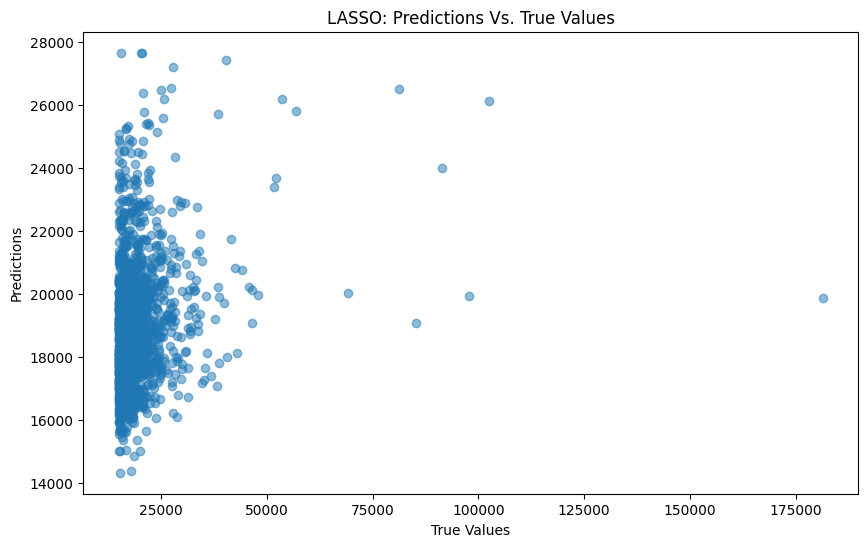

In [ ]:
results_df = pd.DataFrame({'True Values': y_test, 'Predictions': y_test_valid_lm})

plt.figure(figsize=(10, 6))
plt.scatter(results_df['True Values'], results_df['Predictions'], alpha=0.5)

plt.title('LASSO: Predictions Vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# LASSO for extreme values (< 6k)

In [ ]:
final_data = pd.merge(nb_distance, data_min.filter(regex='^min_dist'), on='idmutinvar', how = 'left')

In [ ]:
extreme_values = final_data.loc[final_data["prixm2"]<=6000]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(extreme_values.drop("prixm2",axis=1),
                                                   extreme_values["prixm2"],
                                                   test_size=0.2,
                                                   random_state=42)
print(X_train.shape)
print(X_test.shape)

(7048, 30)
(1763, 30)


In [ ]:
categorical_cols = extreme_values.drop('prixm2',axis=1).select_dtypes(include=['object']).columns
numerical_cols = extreme_values.drop('prixm2',axis=1).select_dtypes(exclude=['object']).columns

# preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train_trans = pd.DataFrame(preprocessor.fit_transform(X_train))
print(X_train_trans.shape)
X_test_trans = pd.DataFrame(preprocessor.fit_transform(X_test))
print(X_test_trans.shape)

(7048, 51)
(1763, 51)


In [ ]:
start_time = time.time()

lasso_model = Lasso(max_iter=50000)

lasso_param = {'alpha':  np.arange(0.001, 1, 0.05) }

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rmse = make_scorer(mean_squared_error, squared=False)

grid_lasso = GridSearchCV(estimator=lasso_model,
                          param_grid = lasso_param,
                          scoring=rmse,
                          refit='r2',
                          cv=cv,
                          error_score='raise',
                          n_jobs=-1)

grid_lasso.fit(X_train_trans, y_train)

print("LASSO RESULTS")
print(f"Mean square error : {grid_lasso.cv_results_['mean_test_score'].mean()}")
print(f"Best parameter : {grid_lasso.best_params_}")
#print(f"Best score : {grid_lasso.best_score_}")

print(f"{int(round(time.time() - start_time,0)//60)} min {int(round(time.time() - start_time,0)%60)}")

LASSO RESULTS
Mean square error : 2095.7063893986046
Best parameter : {'alpha': 0.001}
0 min 56


In [ ]:
print("\nLASSO RESULTS")
lasso_model = Lasso(alpha=grid_lasso.best_params_['alpha'],
                 fit_intercept=True,
                 max_iter=50000)
lasso_model.fit(X_train_trans, y_train)
y_test_valid_lm = lasso_model.predict(X_test_trans)

print('Mean Squared Error (MSE):', np.sqrt(metrics.mean_squared_error(y_test, y_test_valid_lm)))
print('R^2:', metrics.r2_score(y_test, y_test_valid_lm))


LASSO RESULTS
Mean Squared Error (MSE): 2094.5395185459884
R^2: 0.11286984536928313


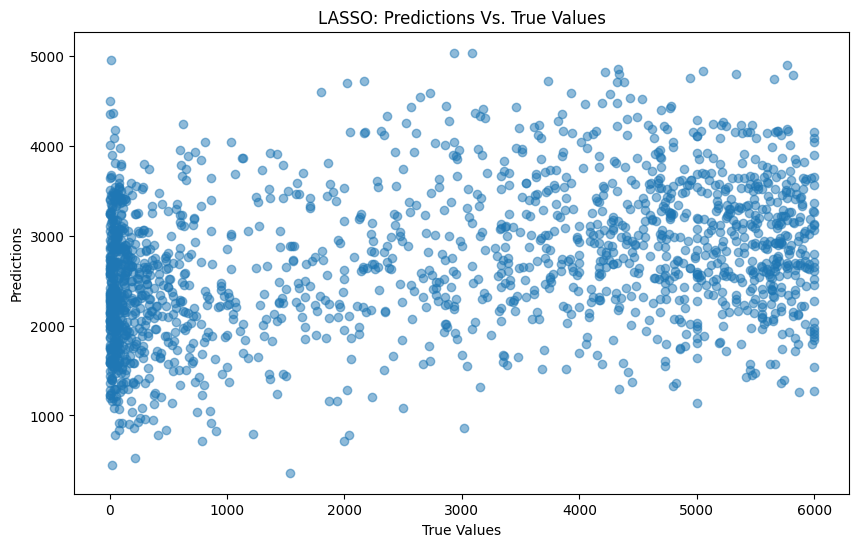

In [ ]:
results_df = pd.DataFrame({'True Values': y_test, 'Predictions': y_test_valid_lm})

plt.figure(figsize=(10, 6))
plt.scatter(results_df['True Values'], results_df['Predictions'], alpha=0.5)

plt.title('LASSO: Predictions Vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()